Final Loss: 1.0897747
Accuracy: 200.0


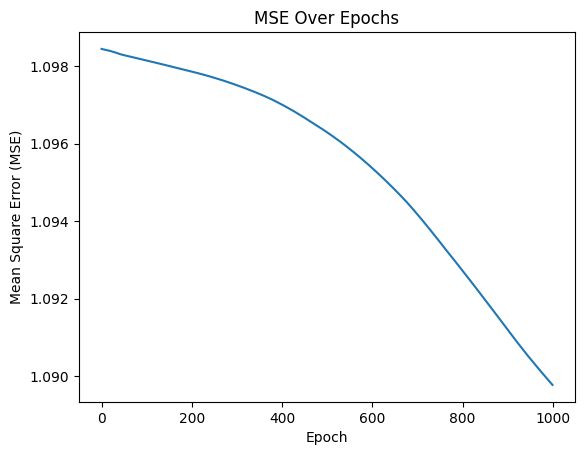

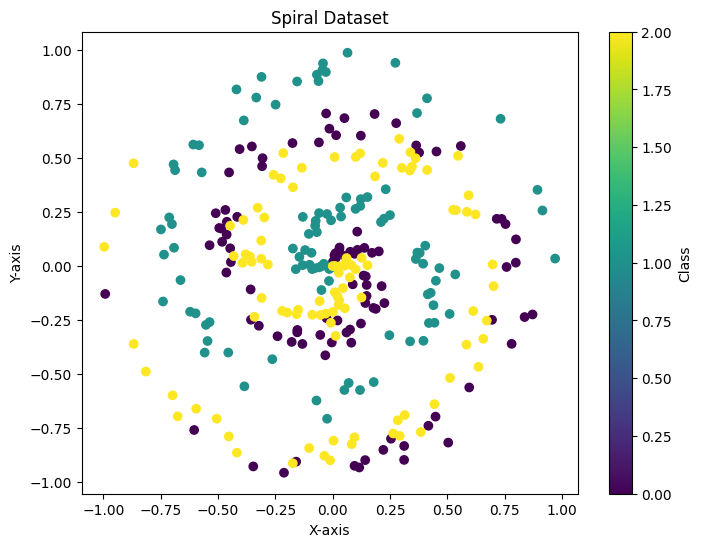

In [2]:
import numpy as np
import nnfs
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data

nnfs.init()

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dvalues = np.dot(dvalues, self.weights.T)

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dvalues = dvalues.copy()
        self.dvalues[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.inputs = inputs
        self.output = probabilities

    def backward(self, dvalues):
        self.dvalues = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dvalues[index] = np.dot(jacobian_matrix, single_dvalues)

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dvalues = dvalues.copy()
        self.dvalues[range(samples), y_true] -= 1
        self.dvalues = self.dvalues / samples

# Initialize data
X, y = spiral_data(samples=100, classes=3)

# Create network layers
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

# Initialize loss and an array to store MSE
loss_function = Loss_CategoricalCrossentropy()
mse_history = []

# Learning rate and number of epochs
learning_rate = 0.1
epochs = 1000

# Training loop
for epoch in range(epochs):
    # Forward propagation
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # Calculate loss
    loss = loss_function.calculate(activation2.output, y)

    # Calculate MSE and store it
    mse = np.mean(loss)
    mse_history.append(mse)

    # Backpropagation
    loss_function.backward(activation2.output, y)
    dense2.backward(loss_function.dvalues)
    activation1.backward(dense2.dvalues)
    dense1.backward(activation1.dvalues)

    # Update weights and biases using gradient descent
    dense1.weights -= learning_rate * dense1.dweights
    dense1.biases -= learning_rate * dense1.dbiases
    dense2.weights -= learning_rate * dense2.dweights
    dense2.biases -= learning_rate * dense2.dbiases

# Calculate accuracy
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
predictions = np.argmax(activation2.output, axis=0)
true_labels = np.argmax(y, axis=0)
accuracy = np.mean(true_labels)

# Print loss value and accuracy
print("Final Loss:", loss)
print("Accuracy:", accuracy)

# Plot the MSE graph
plt.plot(range(epochs), mse_history)
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error (MSE)')
plt.title('MSE Over Epochs')
plt.show()

import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data

# Generate spiral data
X, y = spiral_data(samples=100, classes=3)

# Plot the spiral dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Spiral Dataset')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar(label='Class')
plt.show()